# Import libraries

In [1]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.daily_features import *  
import matplotlib.pyplot as plt
from model.model import *
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
from sklearn.model_selection import train_test_split
from zigzag import peak_valley_pivots

# Import data

In [2]:
tse.download(
    symbols = ['فولاد'],
    adjust = True, 
    write_to_csv = True, 
    include_jdate = True
)
folad = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
foladHist = folad.history
foladClient = folad.client_types

foladHist = foladHist[foladHist.columns[:-1].insert(0, foladHist.columns[-1]).to_list()] # change location of jdate

print(f'Shape of Folad price history: {foladHist.shape}')
print(f'{foladHist.info()}')
foladHist.head()

Shape of Folad price history: (3495, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3495 entries, 0 to 3494
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   jdate      3495 non-null   object        
 1   date       3495 non-null   datetime64[ns]
 2   open       3495 non-null   float64       
 3   high       3495 non-null   float64       
 4   low        3495 non-null   float64       
 5   adjClose   3495 non-null   float64       
 6   value      3495 non-null   int64         
 7   volume     3495 non-null   int64         
 8   count      3495 non-null   int64         
 9   yesterday  3495 non-null   float64       
 10  close      3495 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 300.5+ KB
None


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [3]:
print(f"Shape of Folad's client history: {foladClient.shape}")
print(f'{foladClient.info()}')
foladClient.head()

Shape of Folad's client history: (3110, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3110 entries, 0 to 3109
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3110 non-null   object 
 1   individual_buy_count         3110 non-null   object 
 2   corporate_buy_count          3110 non-null   object 
 3   individual_sell_count        3110 non-null   object 
 4   corporate_sell_count         3110 non-null   object 
 5   individual_buy_vol           3110 non-null   object 
 6   corporate_buy_vol            3110 non-null   object 
 7   individual_sell_vol          3110 non-null   object 
 8   corporate_sell_vol           3110 non-null   object 
 9   individual_buy_value         3110 non-null   object 
 10  corporate_buy_value          3110 non-null   object 
 11  individual_sell_value        3110 non-null   object 
 12  corporate_sell_value         311

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20230111,3622,27,3313,11,94907917,40421557,126720890,8608584,609672688100,259453509830,813755541880,55370656050,6423.833831,6421.636889,6418.691636,6432.028316,-31812973.0
1,20230110,4872,46,6496,40,259726550,154535038,224212326,190049262,1685892142090,1006804529480,1456133492940,1236563178630,6491.027360,6494.439975,6515.056666,6506.540281,35514224.0
2,20230109,2662,23,3453,22,110148262,66736436,119814052,57070646,674979382410,410141419880,734567517370,350553284920,6127.916775,6130.896210,6145.689588,6142.444663,-9665790.0
3,20230108,4002,26,3005,24,135680159,76674895,111442883,100912171,823351511330,468291657370,679252627340,612390541360,6068.326551,6095.074078,6107.496559,6068.549862,24237276.0
4,20230107,2870,16,2230,14,97851744,6458747,72024374,32286117,577151110730,38174684760,425805902340,189519893150,5898.219972,5911.969500,5910.540351,5870.011967,25827370.0


In [4]:
foladClient = foladClient.iloc[::-1]
foladClient.reset_index(
    drop = True,
    inplace = True
)
foladClient['date'] = foladClient['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
foladClient.iloc[:, 1:] = foladClient.iloc[:, 1:].astype('float')

foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [5]:
marketIndex = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3408, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


In [6]:
foladHist = foladHist[foladHist.columns].merge(
    marketIndex, 
    how = 'left', 
    on = 'date'
)
foladHist.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


# Features

In [7]:
calCols = calender_features(foladHist)
candelCols = candlestick_feature(foladHist)
prpCols = prp_based(foladHist)
retCols = ret_based(foladHist)
shiftCols = shift_data(foladHist)
wghtCols = weight_feature(foladHist)

priceFeatures = pd.concat(
    [
        foladHist,
        calCols,
        candelCols,
        prpCols,
        retCols,
        shiftCols,
        wghtCols
    ], axis = 1
)

priceFeatures = priceFeatures.merge(
    indv_nonindv_features(foladClient),
    how = 'left',
    on = 'date'
)

print(f'Shape of price features: {priceFeatures.shape}')
priceFeatures.head()

Shape of price features: (3495, 121)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,12,4,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889437216900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,12,4,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,193879458000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,12,4,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,249241504527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,12,4,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0,16.0,16.0,16.0,16.0,2.492415e+11,126270939.0,5862.0,16.0,16.0,NaN,51666379451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN,1385,12,4,26,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,16.0,NaN,16.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,

In [8]:
bbCols = BB(priceFeatures)
emaCols = EMA(foladHist)
macdCols = MACD(foladHist)
smaCols = SMA(foladHist)
stochasticCols = STOCHASTIC(foladHist)
rsiCols = RSI(foladHist)

indicatorFeatures = pd.concat(
    [
        bbCols,
        emaCols,
        macdCols,
        smaCols,
        stochasticCols,
        rsiCols,
    ], axis = 1
)

print(f'Shape of indicator features: {indicatorFeatures.shape}')
indicatorFeatures.head()

Shape of indicator features: (3495, 35)


,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_buy,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
features = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
print(f'shape of features after concatenation: {features.shape}')

features.dropna(
    axis = 'columns', 
    thresh = len(features) - 450,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features.shape}')
print(f'names of the columns that dropped: {(indicatorFeatures.columns.union(priceFeatures.columns)).difference(features.columns).to_list()}')

features.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
print(f'shape of features after drop non-essential rows: {features.shape}')
features.head()

shape of features after concatenation: (3495, 156)
shape of features after drop non-essential columns: (3495, 150)
names of the columns that dropped: ['BB_buy', 'EMA_buy', 'MACD_buy', 'RSI_buy', 'SMA_buy', 'STOCH_buy']
shape of features after drop non-essential rows: (2967, 150)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position
449,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.0,15.0,14.833333,14.96,14.98,15.4625,0.0,100.0,80.0,100.0,80.0,1.0,49.815169,1.0
450,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000003,14.999997,1.0,14.999977,14.999965,15.112079,15.117827,0.0,0.004086,0.009540,-0.005454,1.0,

In [10]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        foladHist['adjClose'], 
        0.075, 
        -0.075
    ) * -1,
    columns = ['label']
)
signals = pivots.replace(
    to_replace = 0, 
    value = np.nan
)
signals.fillna(
    method = 'ffill', 
    inplace = True
)
# signals.replace(
#     to_replace = -1, 
#     value = 0,  
#     inplace = True
# )
pivots.columns = ['pivots']
signals['date'] = foladHist['date']
pivots['date'] = foladHist['date']

print(f'Number of each class {np.unique(signals["label"], return_counts = True)}')

Number of each class (array([-1.,  1.]), array([1578, 1917], dtype=int64))


In [11]:
initFeatures = features.merge(
    signals,
    how = 'left',
    on = 'date'
)
# initFeatures.to_csv(
#     'initFeatures.csv', 
#     index = False
# )
print(f'Number of initial features: {initFeatures.shape}')
initFeatures

Number of initial features: (2967, 151)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,label
0,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.062500,-0.062500,0.062500,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.00,15.00,14.833333,14.96,14.98,15.4625,0.0,100.000000,80.000000,100.000000,80.000000,1.0,49.815169,1.0,1.0
1,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.000000,-0.066667,0.000000,0.062500,-0.062500,0.062500,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000

# Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    initFeatures.iloc[:, 2:-1].values, 
    initFeatures.iloc[:, -1].values, 
    shuffle = False, 
    random_state = 0
)

Hyperparameters are selected by the Bayesian optimization method. <a href = 'https://www.kaggle.com/alirezahanifi/iran-stock-market-bayesian-optimization-part'>Link</a> to the notebook of this part of the code in Kaggle. 

In [13]:
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport,\
    testClassReport = RFClf(X_train, y_train, X_test, y_test)

print(f'Training classification report:\n{trainClassReport}')
print(f'Testing classification report:\n{testClassReport}')

Training classification report:
              precision    recall  f1-score   support

        -1.0       0.80      0.86      0.83      1038
         1.0       0.87      0.81      0.84      1187

    accuracy                           0.83      2225
   macro avg       0.83      0.83      0.83      2225
weighted avg       0.84      0.83      0.83      2225

Testing classification report:
              precision    recall  f1-score   support

        -1.0       0.78      0.68      0.73       370
         1.0       0.72      0.80      0.76       372

    accuracy                           0.74       742
   macro avg       0.75      0.74      0.74       742
weighted avg       0.75      0.74      0.74       742



In [17]:
# output for API 

# output = pd.DataFrame()
# output.index = initFeatures['jdate']
# labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
# output['labelProb'] = labelProb
# output = output.to_dict()
# output = output['labelProb']
# output

{'1388-02-15': 0.827966933105912,
 '1388-02-16': 0.8379117600172695,
 '1388-03-16': 0.9179867342396337,
 '1388-03-17': 0.8960031173385649,
 '1388-03-18': 0.806727455134264,
 '1388-03-19': 0.7731604070726829,
 '1388-03-20': 0.8958042535492812,
 '1388-03-23': 0.9043516373755651,
 '1388-03-24': 0.6072895194257348,
 '1388-04-02': 0.5910311563323001,
 '1388-04-03': 0.5738960078661698,
 '1388-04-06': 0.5727397237222581,
 '1388-04-07': 0.5220183154080305,
 '1388-04-08': 0.5165919493380018,
 '1388-04-09': 0.5102783239677857,
 '1388-04-10': 0.5151640338515805,
 '1388-04-13': 0.4551218805934088,
 '1388-04-14': 0.4849460938669146,
 '1388-04-16': 0.5047167840825793,
 '1388-04-20': 0.5308546125919319,
 '1388-04-21': 0.5294636638380982,
 '1388-04-22': 0.5277472238058813,
 '1388-04-23': 0.5536876457605338,
 '1388-04-24': 0.6508930699148971,
 '1388-04-27': 0.70453176594312,
 '1388-04-28': 0.6985346708405906,
 '1388-04-30': 0.6658190088867159,
 '1388-04-31': 0.7070429812885496,
 '1388-05-03': 0.7360719

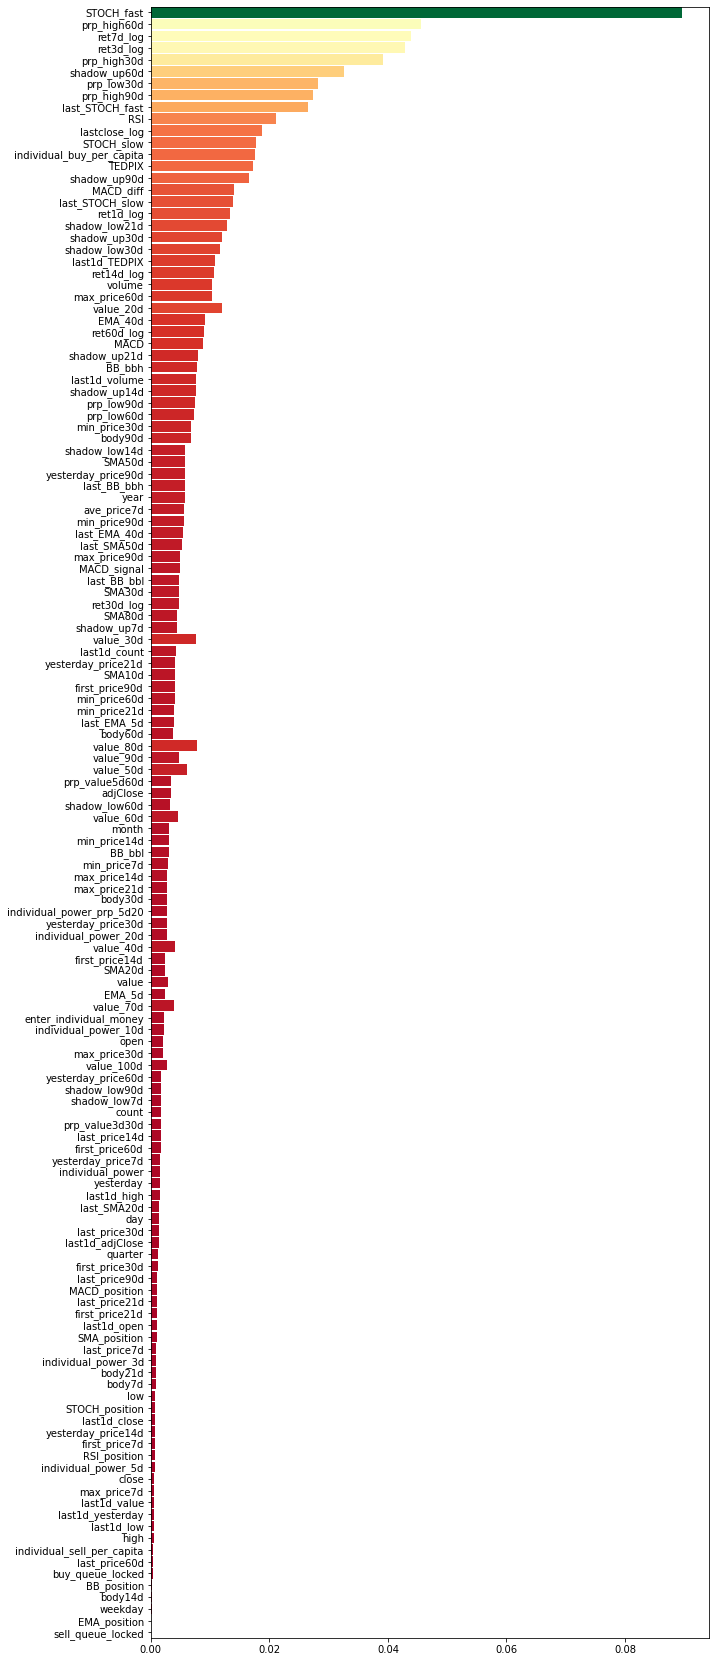

In [ ]:
importance = pd.DataFrame(
    {
        'Features': initFeatures.iloc[:, 2:-1].columns,
        'Scores': featureImport
    }
).sort_values(by = ['Scores'])

plt.figure(figsize = (10, 30))
plt.tight_layout()

plt.barh(
    y = importance['Features'],
    width = importance['Scores'],
    height = 0.9,
    color = plt.cm.get_cmap('RdYlGn')(importance['Scores'] / max(importance['Scores']))
)
plt.margins(y=0)

In [ ]:
def convertLabel(df, colName):
    name = str(colName + '01')
    df.loc[initFeatures[colName] == -1, name] = 0
    df[name] = df[name].fillna(1)
    return df
    
initFeatures['priChange'] = initFeatures['adjClose'] - initFeatures['yesterday']
labelPred = np.concatenate((trainPred, testPred), axis = 0)
initFeatures['labelPred'] = labelPred
labelProb = np.concatenate((trainProb, testProb), axis = 0)[:,1]
initFeatures['labelProb'] = labelProb

initFeatures = convertLabel(initFeatures, 'label')
initFeatures = convertLabel(initFeatures, 'labelPred')

initFeatures = initFeatures.merge(
    pivots,
    how = 'left',
    on = 'date'
)

initFeatures.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,shadow_up7d,shadow_low7d,body7d,shadow_up14d,shadow_low14d,body14d,shadow_up21d,shadow_low21d,body21d,shadow_up30d,shadow_low30d,body30d,shadow_up60d,shadow_low60d,body60d,shadow_up90d,shadow_low90d,body90d,max_price7d,min_price7d,ave_price7d,first_price7d,last_price7d,yesterday_price7d,max_price14d,min_price14d,first_price14d,last_price14d,yesterday_price14d,max_price21d,min_price21d,first_price21d,last_price21d,yesterday_price21d,max_price30d,min_price30d,first_price30d,last_price30d,yesterday_price30d,max_price60d,min_price60d,first_price60d,last_price60d,yesterday_price60d,max_price90d,min_price90d,first_price90d,last_price90d,yesterday_price90d,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,value,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,enter_individual_money,individual_buy_per_capita,individual_sell_per_capita,individual_power,individual_power_3d,individual_power_5d,individual_power_10d,individual_power_20d,individual_power_prp_5d20,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,label,priChange,labelPred,labelProb,label01,labelPred01,pivots
0,1388-02-15,2009-05-05,15.0,15.0,15.0,15.0,1081376640,586112,41,15.0,15.0,8699.5,1388,2,1,15,3,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.214286,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,1.041980,0.759095,0.000000,0.000000,0.000000,0.000000,0.000000,-0.125163,0.000000,0,0,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1081376640,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,3.059118e+09,2.310900e+09,2.418149e+09,2.313320e+09,2.470778e+09,3.837590e+09,3.865225e+09,4.283519e+09,4.586396e+09,2.605398e+08,6.939266e+07,3.095620e+07,2.241640,1.751292,2.161544,2.610384,1.299605,0.601239,15.000003,14.999997,15.000003,14.999997,1.0,14.999965,14.999948,15.117827,15.123870,0.0,0.003671,0.011510,-0.007839,1.0,15.0,15.0,15.0,14.833333,14.96,14.98,15.4625,0.0,100.0,80.0,100.0,80.0,1.0,49.815169,1.0,1.0,0.0,1.0,0.828300,1.0,1.0,0
1,1388-02-16,2009-05-06,15.0,15.0,15.0,15.0,91486200,49452,11,15.0,15.0,8774.2,1388,2,1,16,4,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0,-0.066667,0.0000,0.0,-0.066667,0.000000,0.0,-0.066667,0.000000,0.0625,-0.0625,0.0625,15.0,14.0,15.200000,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,17.0,14.0,16.0,15.0,16.0,1.000000,0.882353,0.882353,1.071429,1.071429,1.071429,0.729210,0.722844,0.000000,0.000000,0.000000,0.000000,0.068993,-0.125163,0.000000,0,0,15.0,15.0,15.0,15.0,1.081377e+09,586112.0,41.0,15.0,15.0,8699.5,91486200,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,3.039489e+09,2.254816e+09,2.418696e+09,2.299024e+09,2.338820e+09,3.783634e+09,3.790551e+09,4.222707e+09,4.584972e+09,0.000000e+00,9.148620e+07,9.148620e+06,10.000000,2.205688,3.506739,5.561177,5.004484,1.427105,15.000003,14.999997,15.000003,

Return in passive invesitng in train section: 5947%
Return in passive invesitng in test section: 735%
Max return in train section based on zigzag: 11927%
Max return in test section based on zigzag: 2239%
Return in train section based on prediction: 5980%
Return in test section based on prediction: 718%


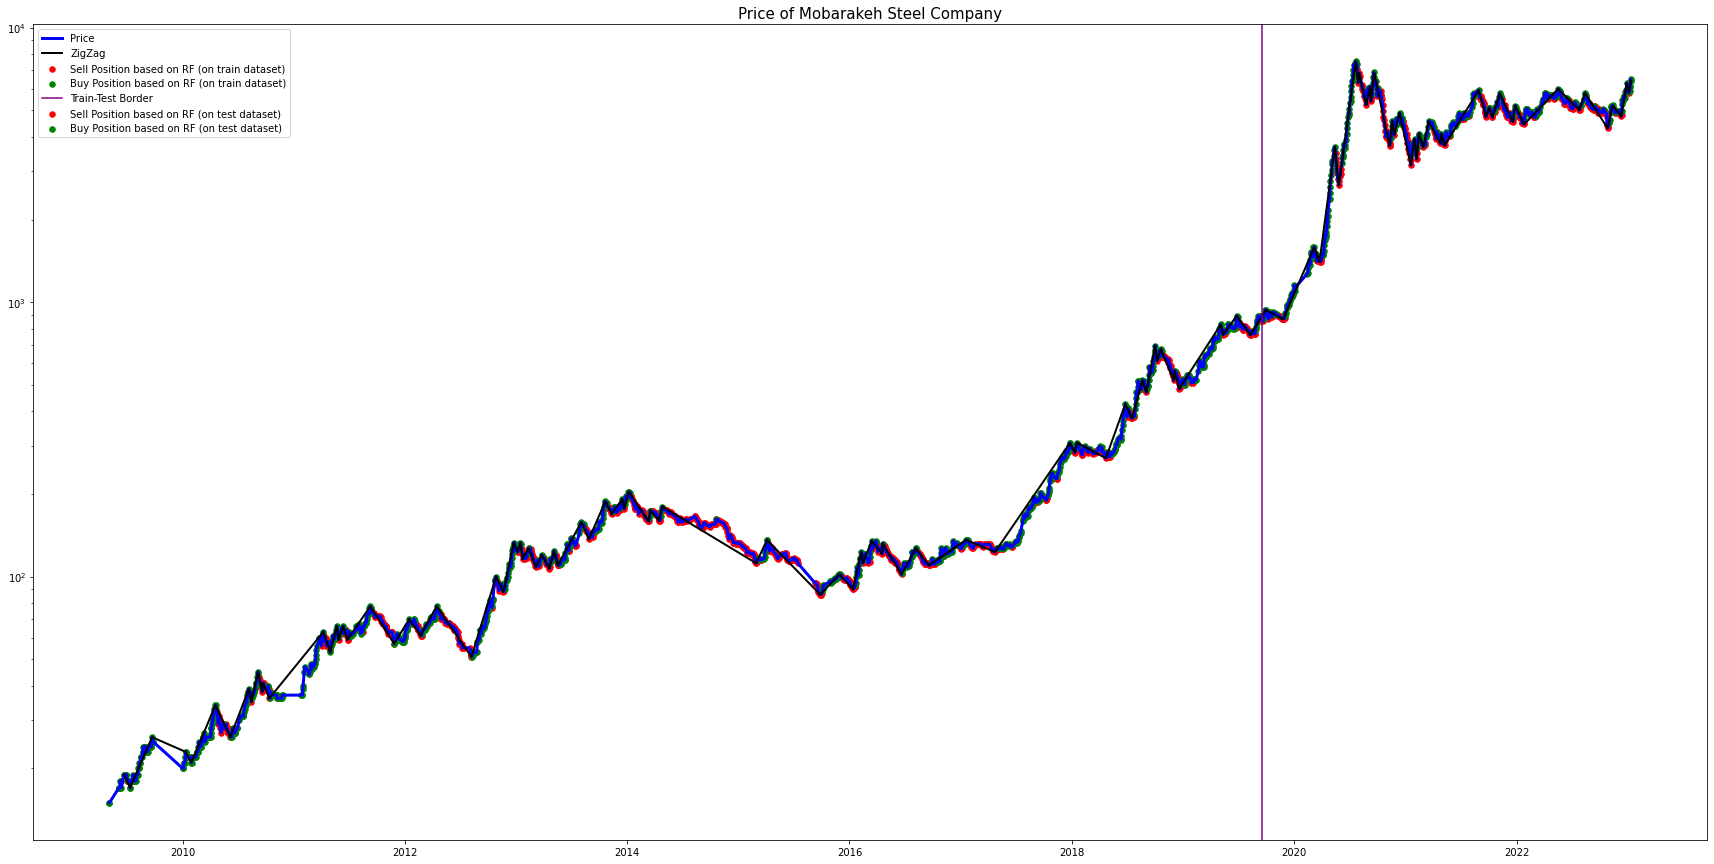

In [ ]:
def plotLabel(df, trainPred, testPred):
    
    date = df['date']
    price = df['adjClose']
    label = df['label']
    neutralIndex = df['pivots'] == 0
    trainBuy = df.loc[df.index < len(trainPred)].loc[trainPred == 1].index 
    trainSell = df.loc[df.index < len(trainPred)].loc[trainPred == -1].index
    trainTestBorder = df.loc[df.index == len(trainPred)].index
    testBuy = df.loc[df.index >= len(trainPred)].loc[testPred == 1].index 
    testSell = df.loc[df.index >= len(trainPred)].loc[testPred == -1].index 
    
    plt.figure(figsize = (30, 15))
    plt.title('Price of Mobarakeh Steel Company', fontsize = 15)
    plt.plot(
        date,
        price,
        color = 'blue',
        lw = 3,
        label = 'Price'
    )    
    plt.plot(
        date.iloc[np.where(~neutralIndex)], 
        price.iloc[np.where(~neutralIndex)],
        color = 'black',
        lw = 2,
        label = 'ZigZag'
    )


    # train
    plt.scatter(
        date.iloc[trainSell] , 
        price.iloc[trainSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on train dataset)'
    )
    plt.scatter(
        date.iloc[trainBuy], 
        price.iloc[trainBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on train dataset)'
    )
    plt.yscale('log')

    plt.axvline(date.iloc[trainTestBorder], color = 'purple', label = 'Train-Test Border')

    # test
    plt.scatter(
        date.iloc[testSell] , 
        price.iloc[testSell],
        color = 'red',
        s = 30,
        label = 'Sell Position based on RF (on test dataset)'
    )
    plt.scatter(
        date.iloc[testBuy], 
        price.iloc[testBuy],
        color = 'green',
        s = 30,
        label = 'Buy Position based on RF (on test dataset)'
    )
    plt.yscale('log')
    plt.legend()

print(f'Return in passive invesitng in train section: {(initFeatures["adjClose"].iloc[len(trainPred) - 1]  / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in passive invesitng in test section: {(initFeatures["adjClose"].iloc[-1]  / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Max return in train section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Max return in test section based on zigzag: {((initFeatures["priChange"] * initFeatures["label01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Return in train section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[:len(trainPred)].sum() / initFeatures["adjClose"].iloc[0]):0.0%}')
print(f'Return in test section based on prediction: {((initFeatures["priChange"] * initFeatures["labelPred01"].shift(2)).iloc[len(trainPred):].sum() / initFeatures["adjClose"].iloc[len(trainPred)]):0.0%}')
plotLabel(initFeatures, trainPred, testPred)

# Bayesian Optimization

In [ ]:
# def rfcScore(
#     n_estimators,
#     min_samples_split,
#     min_samples_leaf,
#     max_depth):
    
#     n_estimators = int(n_estimators)
#     min_samples_split = int(min_samples_split)
#     min_samples_leaf = int(min_samples_leaf)
#     max_depth = int(max_depth)
    
#     params = {
#         'n_estimators': n_estimators,
#         'criterion': 'entropy',
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'max_depth': max_depth,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 1,
#         'class_weight': 'balanced_subsample'
#     }

#     rfc = RandomForestClassifier(
#         **params
#     )

#     score = cross_val_score(
#         rfc, 
#         X = X_train,
#         y = y_train,
#         scoring = 'f1_weighted'
#     ).mean()

#     return score

# def RFClf(train_data, train_label, test_data, test_label, params):
    
#     clf = RandomForestClassifier(
#         n_estimators = int(params['n_estimators']),
#         max_depth = int(params['max_depth']),
#         min_samples_leaf = int(params['min_samples_leaf']),
#         min_samples_split = int(params['min_samples_split']),
#         criterion = 'entropy',
#         class_weight = 'balanced_subsample',
#         random_state = 0
#     )

#     clf.fit(train_data, train_label)
    
#     trainPred = clf.predict(train_data)
#     testPred = clf.predict(test_data)

#     trainProb = clf.predict_proba(train_data)
#     testProb = clf.predict_proba(test_data)

#     featureImport = clf.feature_importances_

#     trainClassReport = metrics.classification_report(train_label, trainPred)
#     testClassReport = metrics.classification_report(test_label, testPred)

#     return trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport

# rfcBound = {
#     'n_estimators': (100, 200),
#     'min_samples_split': (2, 5),
#     'min_samples_leaf': (1, 5),
#     'max_depth': (4, 8)
# }
# optimizer = BayesianOptimization(
#     f = rfcScore, 
#     pbounds = rfcBound,
#     random_state = 1
# )
# optimizer.maximize(
#     init_points = 3,
#     n_iter = 5,
# )

# print(f"Selected parameters: {optimizer.max['params']}\n")

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test, optimizer.max['params'])

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')